# Импорты

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

## Дефолтные настройки Matplotlib

In [2]:
import matplotlib.pyplot as plt

# устанавливаем дефолтные размеры шрифтов
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Константы

In [3]:
DATA_PATH = 'data/'
IMAGES_PATH = Path() / "imgs"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
SEED = 30




np.random.seed(SEED)

In [4]:
convert_type_dict = {'parameter1': float,
                    'parameter2': float,
                    'criteria1': float,
                    'criteria2': float,
                    'constraint1': bool,
                    'constraint2': bool,
                    }

Загрузка датасета

In [5]:
def load_data(path: Path):
    print("Read data set from path {path}".format(path=path))
    df = pd.read_csv(path).astype(convert_type_dict)
    return df

In [6]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Непосредственно загрузка

In [7]:
data_1_path = Path(DATA_PATH+"DataSet900.csv")
# data_2_path = Path("data/DataSet1000.csv")
# data_3_path = Path("data/DataSet100000.csv")
# data_4_path = Path("data/DataSet129600.csv")

data_1 = load_data(data_1_path)
# data_2 = load_data(data_2_path)
# data_3 = load_data(data_3_path)
# data_4 = load_data(data_4_path)

dataset = data_1

Read data set from path data\DataSet900.csv


In [8]:
lol = dataset[['parameter1', 'parameter2']]

In [9]:
import torch
import pickle
from torch import nn
from torch.utils.data import DataLoader, Dataset

## Установить роботу с куда или на цп

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Working with data

In [11]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, features, targets):
        """
        Инициализация датасета.
        :param features: Numpy массив или список списков с признаками.
        :param targets: Numpy массив или список с целевыми значениями.
        """
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        """
        Получение одного элемента датасета по индексу.
        """
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)
    
    def get_features_targets(self, idx):
        return self.features[idx], self.targets[idx]


# Model


- layer_sizes - список, содержащий количество нейронов для каждого скрытого слоя.
- activation_fn - функция активации для скрытых слоев. По умолчанию используется ReLU. Вы можете передать любую функцию активации из torch.nn.functional, такую как F.relu, F.tanh и т.д.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionModel(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size,
                 layer_sizes=[64], 
                 activation_fn=F.relu):
        super(RegressionModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.layer_sizes = layer_sizes
        self.activation_fn = activation_fn
        
        self.layers = nn.ModuleList()
        
        # Создаем слои в соответствии с layer_sizes
        prev_size = input_size
        for size in layer_sizes:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
        
        # Добавляем выходной слой
        self.layers.append(nn.Linear(prev_size, output_size))
        self.activation_fn = activation_fn

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_fn(layer(x))
        # Для выходного слоя не применяем функцию активации
        x = self.layers[-1](x)
        return x


In [13]:
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm


class Trainer:
    def __init__(self, 
                 model: RegressionModel, 
                 criterion=None, 
                 optimizer=None, 
                 device='cpu',
                 print_every=None,
                 verbose=False):
        
        self.model = model
        self.criterion = criterion if criterion else torch.nn.MSELoss()
        self.optimizer = optimizer if optimizer else torch.optim.Adam(model.parameters(), lr=0.001)
        self.print_every = print_every
        self.device = device
        self.verbose = verbose
                
        self.loss_values = []
        self.mae_values = []  # Для средней абсолютной ошибки на тренировочных данных
        self.val_loss_values = []
        self.val_mae_values = []  # Для средней абсолютной ошибки на валидационных данных

    def _train(self, train_dataloader: DataLoader):
        self.model.train()
        epoch_losses = []
        epoch_maes = []
            
        for inputs, targets in train_dataloader:
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            epoch_losses.append(loss.item())
            epoch_maes.append(torch.abs(outputs - targets).mean().item())

        epoch_loss = np.mean(epoch_losses)
        epoch_mae = np.mean(epoch_maes)
        self.loss_values.append(epoch_loss)
        self.mae_values.append(epoch_mae)
                        
        return epoch_loss, epoch_mae
                
    def _eval(self, val_dataloader: DataLoader):
        self.model.eval()
        val_losses = []
        val_maes = []
        
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                val_losses.append(loss.item())
                val_maes.append(torch.abs(outputs - targets).mean().item())
                
        # Сохранение и печать результатов
        val_epoch_loss = np.mean(val_losses)
        val_epoch_mae = np.mean(val_maes)
        self.val_loss_values.append(val_epoch_loss)
        self.val_mae_values.append(val_epoch_mae)
    
        return val_epoch_loss, val_epoch_mae
    
    def  fit(self, n_epochs, train_dataloader, val_dataloader):
        for epoch in range(n_epochs):
            
            # if self.verbose:
            #     train_dataloader = tqdm(train_dataloader)
            #     val_dataloader = tqdm(val_dataloader)
                
            epoch_loss, epoch_mae = self._train(train_dataloader)
            val_epoch_loss, val_epoch_mae = self._eval(val_dataloader)   
                 
            if self.print_every and (epoch + 1) % self.print_every == 0:
                print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, MAE: {epoch_mae:.4f}, Val Loss: {val_epoch_loss:.4f}, Val MAE: {val_epoch_mae:.4f}')
                # if self.verbose:
                #     val_dataloader.set_description(f"Loss={val_epoch_loss:.4}; MAE:{val_epoch_mae:.4}")
                #     train_dataloader.set_description(f"Loss={epoch_loss:.4}; MAE:{epoch_mae:.4}")
        return val_epoch_loss, val_epoch_mae
    
    def _init_verbose(self, epoch, train_dataloader, val_dataloader):
        if self.print_every and (epoch + 1) % self.print_every == 0:
                if self.verbose:
                    train_dataloader = tqdm(train_dataloader)
                    val_dataloader = tqdm(val_dataloader)
        pass
    
    def _verbose(self):
        
        pass

    def plot_metrics(self):
        epochs_range = range(1, len(self.loss_values) + 1)
        fig = plt.figure(figsize=(15, 6))  # Устанавливаем размер фигуры
        
        # График потерь
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs_range, self.loss_values, label='Training Loss', color='tab:red')
        ax1.plot(epochs_range, self.val_loss_values, label='Validation Loss', color='tab:blue')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax1.legend(loc='upper left')

        # График MAE
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(epochs_range, self.mae_values, label='Training MAE', color='tab:green')
        ax2.plot(epochs_range, self.val_mae_values, label='Validation MAE', color='tab:orange')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE', color='tab:green')
        ax2.tick_params(axis='y', labelcolor='tab:green')
        ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax2.legend(loc='upper left')        
        
        plt.suptitle('Training Loss and MAE')  # Добавляем общий заголовок для всей фигуры
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Настраиваем layout с учетом общего заголовка
        fig.tight_layout()  # Убедимся, что макет не нарушен
        plt.show()
        
    def predict(self, inputs):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        with torch.no_grad():
            inputs = torch.tensor(inputs, dtype=torch.float32)
            outputs = self.model(inputs)
            return outputs.numpy()
        
    def save_model(self, path):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "model_state_dict": self.model.state_dict(),
            "model_config": {
                'input_size': self.model.input_size,
                'output_size': self.model.output_size,
                'layer_sizes': self.model.layer_sizes,
                'activation_fn': self.model.activation_fn,
            },
            "trainer_config": {
                'criterion': self.criterion,
                'optimizer': self.optimizer,
                'device': self.device,
                'print_every': self.print_every,
            },
        }
        torch.save(checkpoint, path)

    @classmethod
    def load_model(cls, path: str):
        ckpt = torch.load(path)
        keys = ["model_state_dict", "model_config", "trainer_config"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = RegressionModel(
            **ckpt["model_config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(new_model, **ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer


# TrainingManager

In [14]:
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

class TrainingManager:
    def __init__(self, 
                 features: list[str], 
                 targets: list[str],
                 dataset: pd.DataFrame,
                 model_params: dict={}, 
                 train_params: dict={},
                 other_params: dict={}):
        """
        Инициализация менеджера обучения.        
        :param features: Признаки для обучения модели.
        :param targets: Целевые значения.
        :param model_params: Параметры модели, включая размеры слоёв и функцию активации.
        :param train_params: Параметры обучения, включая размер батча, количество эпох и скорость обучения.
        """
        self.uniq_name = '_'.join(features + targets)
        self.data_path = DATA_PATH      
        
        self.features = features
        self.targets = targets
        self.dataset = dataset
        
        self.model_params = model_params
        self.train_params = train_params
        self.other_params  = other_params
        
         
    def _pred_job(self, dataset):
        # Инициализация StandardScaler
        self.scaler_features = StandardScaler()
        self.scaler_targets = StandardScaler()
        
        # Обучение масштабировщика и трансформация признаков и целевой переменной
        scaled_features = self.scaler_features.fit_transform(
            dataset[self.features]
        )
        scaled_targets = self.scaler_targets.fit_transform(
            dataset[self.targets]
        )
        
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_features, 
            scaled_targets, 
            test_size=self.other_params.get('test_size', 0.3), 
            random_state=self.other_params.get('seed', 30), 
            shuffle=self.other_params.get('shuffle', False))        
        
        self.train_dataset = CustomDataset(X_train, y_train)
        self.test_dataset = CustomDataset(X_test, y_test)
        
        model = RegressionModel(
            input_size=len(self.features),
            output_size=len(self.targets),
            **self.model_params
        )        
        optimizer = optim.Adam(model.parameters(), lr=self.train_params.get('learning_rate', 0.001))
        criterion=torch.nn.MSELoss()
        print_every=self.train_params.get('print_every', None)
        
        self.trainer = Trainer(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            # device='cpu',
            print_every=print_every
        )   
    
    def fit(self):
        """
        Запуск процесса обучения.
        """
        self._pred_job(self.dataset)
        
        batch_size = self.train_params.get('batch_size', 64)
        n_epochs = self.train_params.get('n_epochs', 10)
        
        train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        
        self.trainer.fit(n_epochs, train_dataloader, val_dataloader)
        self.trainer.plot_metrics()

    def predict(self, input, transform=True):
        """
        Выполнение предсказаний с помощью обученной модели.
        """
        features = input
        if transform:
            features = self.scaler_features.transform(input)
        else:
            features = input
        scaled_predictions = self.trainer.predict(features)
        return self.scaler_targets.inverse_transform(scaled_predictions)

    def save(self):
        self._save_model()
        self._save_standard_scalar()
 
    def load(self):
        self._load_model()
        self._load_standard_scalar()
    
    def _save_model(self):
        """
        Сохранение обученной модели.        
        """
        self.trainer.save_model(self.data_path+self.uniq_name+'_model_weight.pth')
        
    def _load_model(self):
        """
        Загрузка обученной модели.        
        """
        self.trainer = Trainer.load_model(self.data_path+self.uniq_name+'_model_weight.pth')
        
    def _save_standard_scalar(self):
        with open(self.data_path+self.uniq_name+'_scaler_features.pkl', 'wb') as file: 
            pickle.dump(self.scaler_features, file)
        with open(self.data_path+self.uniq_name+'_scaler_targets.pkl', 'wb') as file: 
            pickle.dump(self.scaler_targets, file)
        
    def _load_standard_scalar(self):
        with open(self.data_path+self.uniq_name+'_scaler_features.pkl', 'rb') as file: 
            self.scaler_features = pickle.load(file)
        with open(self.data_path+self.uniq_name+'_scaler_targets.pkl', 'rb') as file: 
            self.scaler_targets = pickle.load(file)


# Optimizing the Model Parameters

In [15]:
model_params = {
    'layer_sizes': [100],
    'activation_fn': torch.nn.ReLU(),
}

train_params = {
    'batch_size': 32,
    'n_epochs': 100,
    'learning_rate': 0.001,
    'print_every': 10
}
            
other_params = {
    'test_size': 0.9,
    'shuffle': True,
    'seed':  SEED
}

Epoch 10, Loss: 0.3615, MAE: 0.4878, Val Loss: 0.3626, Val MAE: 0.4916
Epoch 20, Loss: 0.0734, MAE: 0.2135, Val Loss: 0.0766, Val MAE: 0.2237
Epoch 30, Loss: 0.0182, MAE: 0.0988, Val Loss: 0.0201, Val MAE: 0.1041
Epoch 40, Loss: 0.0088, MAE: 0.0684, Val Loss: 0.0106, Val MAE: 0.0751
Epoch 50, Loss: 0.0051, MAE: 0.0547, Val Loss: 0.0068, Val MAE: 0.0616
Epoch 60, Loss: 0.0034, MAE: 0.0453, Val Loss: 0.0046, Val MAE: 0.0510
Epoch 70, Loss: 0.0023, MAE: 0.0376, Val Loss: 0.0032, Val MAE: 0.0428
Epoch 80, Loss: 0.0017, MAE: 0.0324, Val Loss: 0.0024, Val MAE: 0.0372
Epoch 90, Loss: 0.0013, MAE: 0.0285, Val Loss: 0.0019, Val MAE: 0.0334
Epoch 100, Loss: 0.0011, MAE: 0.0263, Val Loss: 0.0016, Val MAE: 0.0309


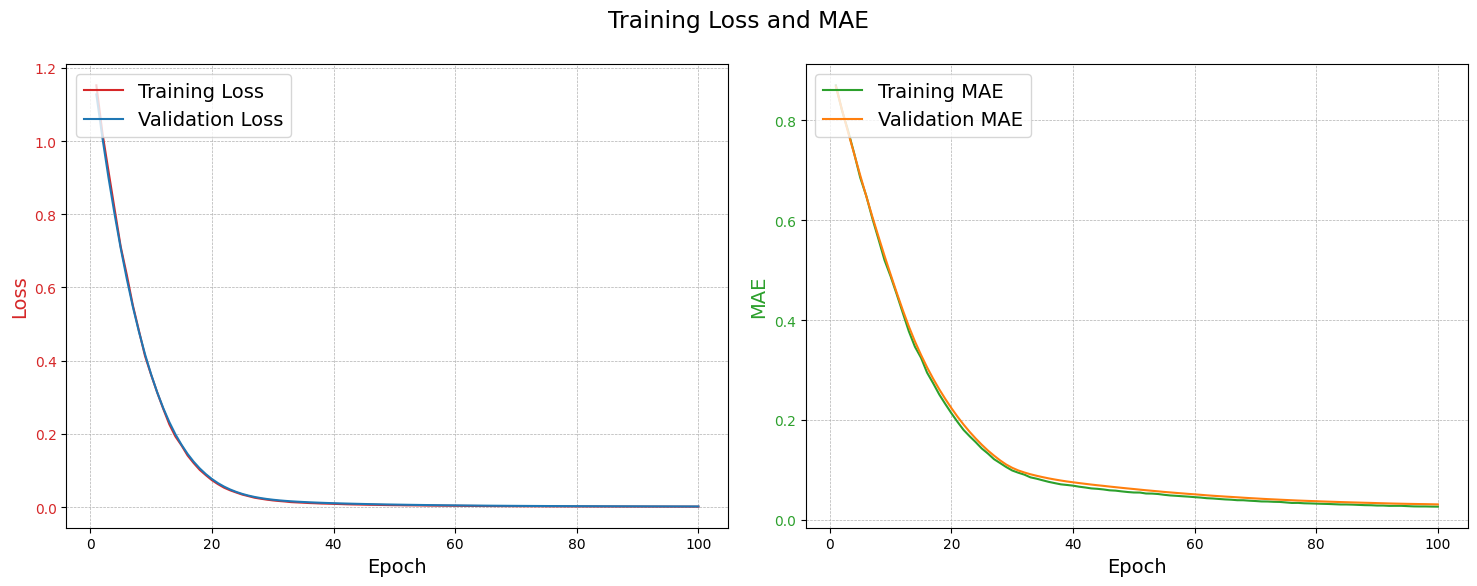

In [16]:
training_manager = TrainingManager(
    dataset=dataset,
    features=['parameter1', 'parameter2', 'constraint1'],
    targets=['criteria1', 'criteria2'],
    model_params=model_params,
    train_params=train_params,    
    other_params=other_params
)

training_manager.fit()


# Тестирование

In [17]:
feature, label = training_manager.test_dataset.get_features_targets([2])

In [18]:
transform_feature = training_manager.scaler_features.inverse_transform(feature)
transform_feature

array([[19., 40.,  0.]])

In [19]:
inverse_label = training_manager.scaler_targets.inverse_transform(label)
inverse_label

array([[  59.  , 3892.43]])

In [20]:
training_manager.predict(transform_feature)

d:\Projects\NLP_course\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[  59.569855, 3998.3906  ]], dtype=float32)

In [21]:
training_manager.save()


In [22]:
new_training_manager = TrainingManager(
    dataset=dataset,
    features=['parameter1', 'parameter2', 'constraint1'],
    targets=['criteria1', 'criteria2'],
    model_params=model_params,
    train_params=train_params,    
    other_params=other_params    
)

In [23]:
new_training_manager.load()


In [24]:
new_training_manager.predict(transform_feature)

d:\Projects\NLP_course\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[  59.569855, 3998.3906  ]], dtype=float32)